### LASSO parameter range experiments: sex prediction

This script is similar to `02_classify_cancer_type/lasso_range_gene.ipynb`, but for prediction of patient sex across cancer types. This won't work for cancer types that only have samples for one sex (e.g. OV, UCEC, TGCT, PRAD) but it should work for most.

In [1]:
import os
import itertools as it

import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
import seaborn as sns

import pancancer_evaluation.config as cfg
import pancancer_evaluation.utilities.data_utilities as du
import pancancer_evaluation.utilities.analysis_utilities as au

%load_ext autoreload
%autoreload 2

In [2]:
base_results_dir = os.path.join(
    cfg.repo_root, '11_sex_prediction', 'results', 'sex_prediction_lasso_range_lr'
)

training_dataset = 'all_other_cancers'
# training_dataset = 'pancancer'
results_dir = os.path.join(base_results_dir, training_dataset)

metric = 'aupr'
nz_cutoff = 5.0

output_plots = False
output_plots_dir = None

### Get coefficient information for each lasso penalty

In [3]:
nz_coefs_df = []

# get coefficient info for training dataset specified above
for coef_info in au.generate_nonzero_coefficients_lasso_range_msi(results_dir):
    (cancer_type,
     seed,
     lasso_param,
     coefs_list) = coef_info
    for fold_no, coefs in enumerate(coefs_list):
        nz_coefs_df.append(
            [cancer_type, lasso_param, seed, fold_no, len(coefs)]
        )
        
nz_coefs_df = pd.DataFrame(
    nz_coefs_df,
    columns=['cancer_type', 'lasso_param', 'seed', 'fold', 'nz_coefs']
)
nz_coefs_df.lasso_param = nz_coefs_df.lasso_param.astype(float)
nz_coefs_df.head()

,cancer_type,lasso_param,seed,fold,nz_coefs
0,KIRP,1000.000,42,0,15293
1,KIRP,1000.000,42,1,15292
2,KIRP,1000.000,42,2,15302
3,KIRP,1000.000,42,3,15293
4,STAD,0.005,1,0,54


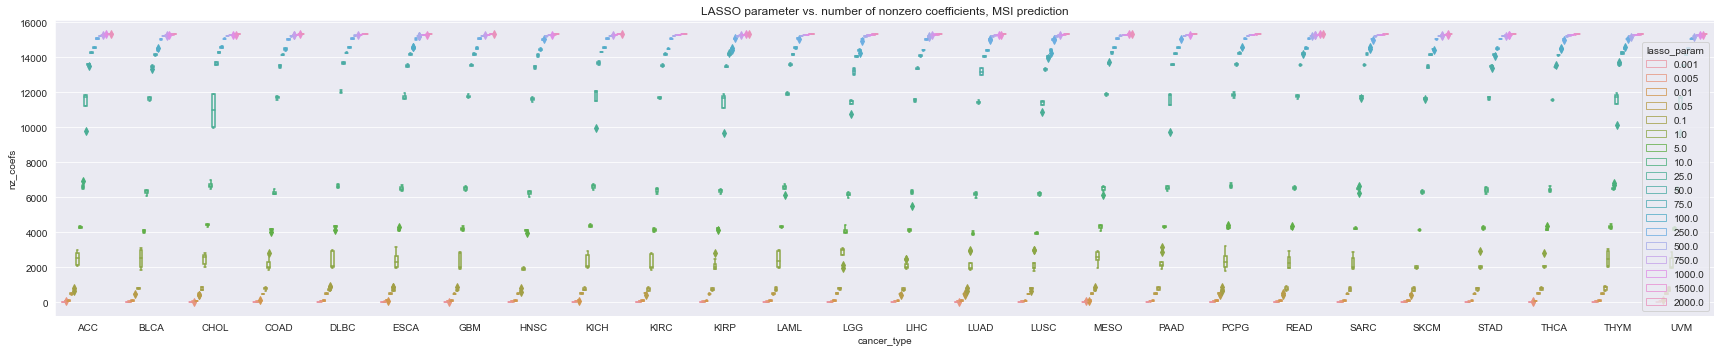

In [4]:
sns.set({'figure.figsize': (24, 5)})

sns.boxplot(
    data=nz_coefs_df.sort_values(by=['cancer_type', 'lasso_param']),
    x='cancer_type', y='nz_coefs', hue='lasso_param'
)

# color the boxplot lines/edges rather than the box fill
# this makes it easier to discern colors at the extremes; i.e. very many or few nonzero coefs
# https://stackoverflow.com/a/72333641
ax = plt.gca()
box_patches = [patch for patch in ax.patches if type(patch) == matplotlib.patches.PathPatch]
num_patches = len(box_patches)
lines_per_boxplot = len(ax.lines) // num_patches
for i, patch in enumerate(box_patches):
    # set the linecolor on the patch to the facecolor, and set the facecolor to None
    col = patch.get_facecolor()
    patch.set_edgecolor(col)
    patch.set_facecolor('None')

    # each box has associated Line2D objects (to make the whiskers, fliers, etc.)
    # loop over them here, and use the same color as above
    for line in ax.lines[i * lines_per_boxplot: (i + 1) * lines_per_boxplot]:
        line.set_color(col)
        line.set_mfc(col)  # facecolor of fliers
        line.set_mec(col)  # edgecolor of fliers

# also fix the legend to color the edges rather than fill
for legpatch in ax.legend_.get_patches():
    col = legpatch.get_facecolor()
    legpatch.set_edgecolor(col)
    legpatch.set_facecolor('None')

plt.title(f'LASSO parameter vs. number of nonzero coefficients, MSI prediction')
plt.tight_layout()

### Get performance information for each lasso penalty

In [5]:
perf_df = au.load_prediction_results_lasso_range_msi(results_dir, training_dataset)
perf_df.drop(columns=['gene'], inplace=True)
perf_df.lasso_param = perf_df.lasso_param.astype(float)

perf_df.head()

,auroc,aupr,holdout_cancer_type,signal,seed,data_type,fold,experiment,lasso_param
0,1.00000,1.00000,SARC,shuffled,42,train,0,all_other_cancers,2000.0
1,0.42609,0.58362,SARC,shuffled,42,test,0,all_other_cancers,2000.0
2,0.77820,0.80000,SARC,shuffled,42,cv,0,all_other_cancers,2000.0
3,1.00000,1.00000,SARC,shuffled,42,train,1,all_other_cancers,2000.0
4,0.43842,0.49816,SARC,shuffled,42,test,1,all_other_cancers,2000.0


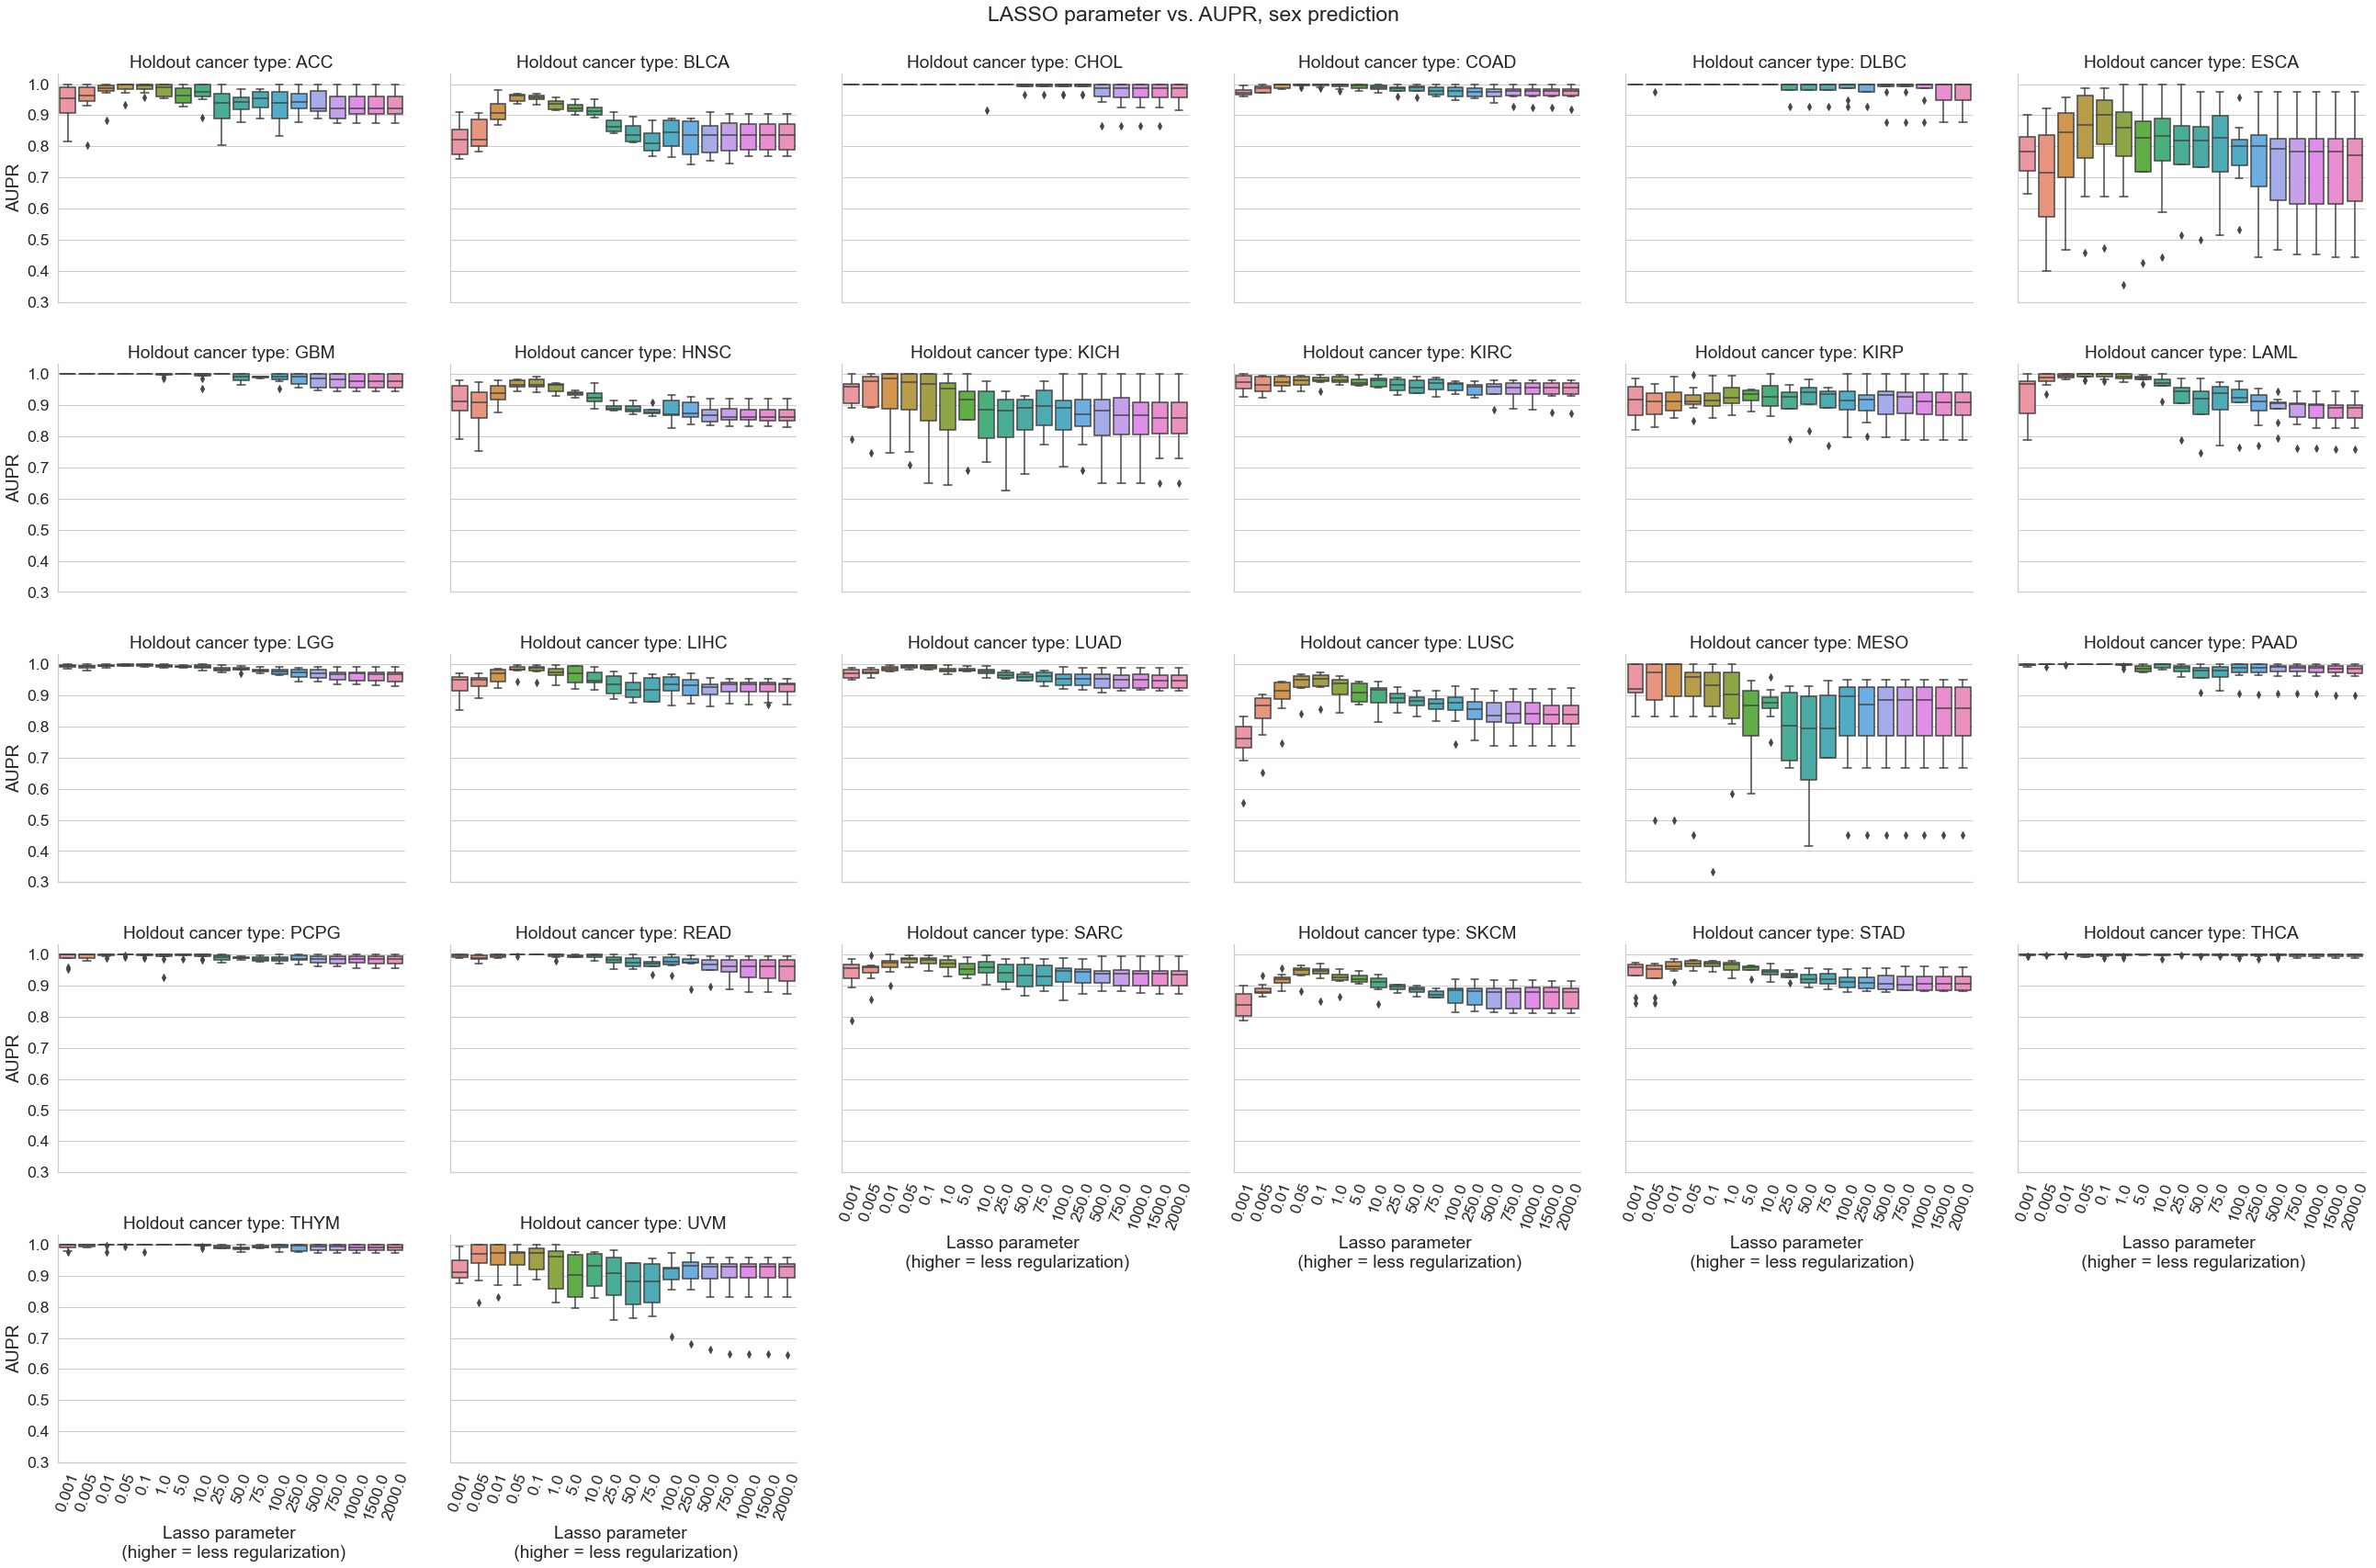

In [6]:
sns.set({'figure.figsize': (24, 5)})
sns.set_style('whitegrid')

with sns.plotting_context('notebook', font_scale=1.6):
    g = sns.catplot(
        data=(
            perf_df[(perf_df.signal == 'signal') &
                    (perf_df.data_type == 'test')]
              .sort_values(by=['holdout_cancer_type', 'lasso_param'])
        ),
        x='lasso_param', y=metric,
        kind='box', col='holdout_cancer_type',
        col_wrap=6, height=4.5, aspect=1.35
    )
    g.set_titles('Holdout cancer type: {col_name}')
    g.set_xlabels('Lasso parameter \n (higher = less regularization)')
    g.set_ylabels(f'{metric.upper()}')
    g.set_xticklabels(rotation=70)
    plt.suptitle(f'LASSO parameter vs. {metric.upper()}, sex prediction', y=1.02)

if output_plots:
    output_plots_dir.mkdir(exist_ok=True)
    plt.savefig(output_plots_dir / f'msi_lasso_boxes.png',
                dpi=200, bbox_inches='tight')

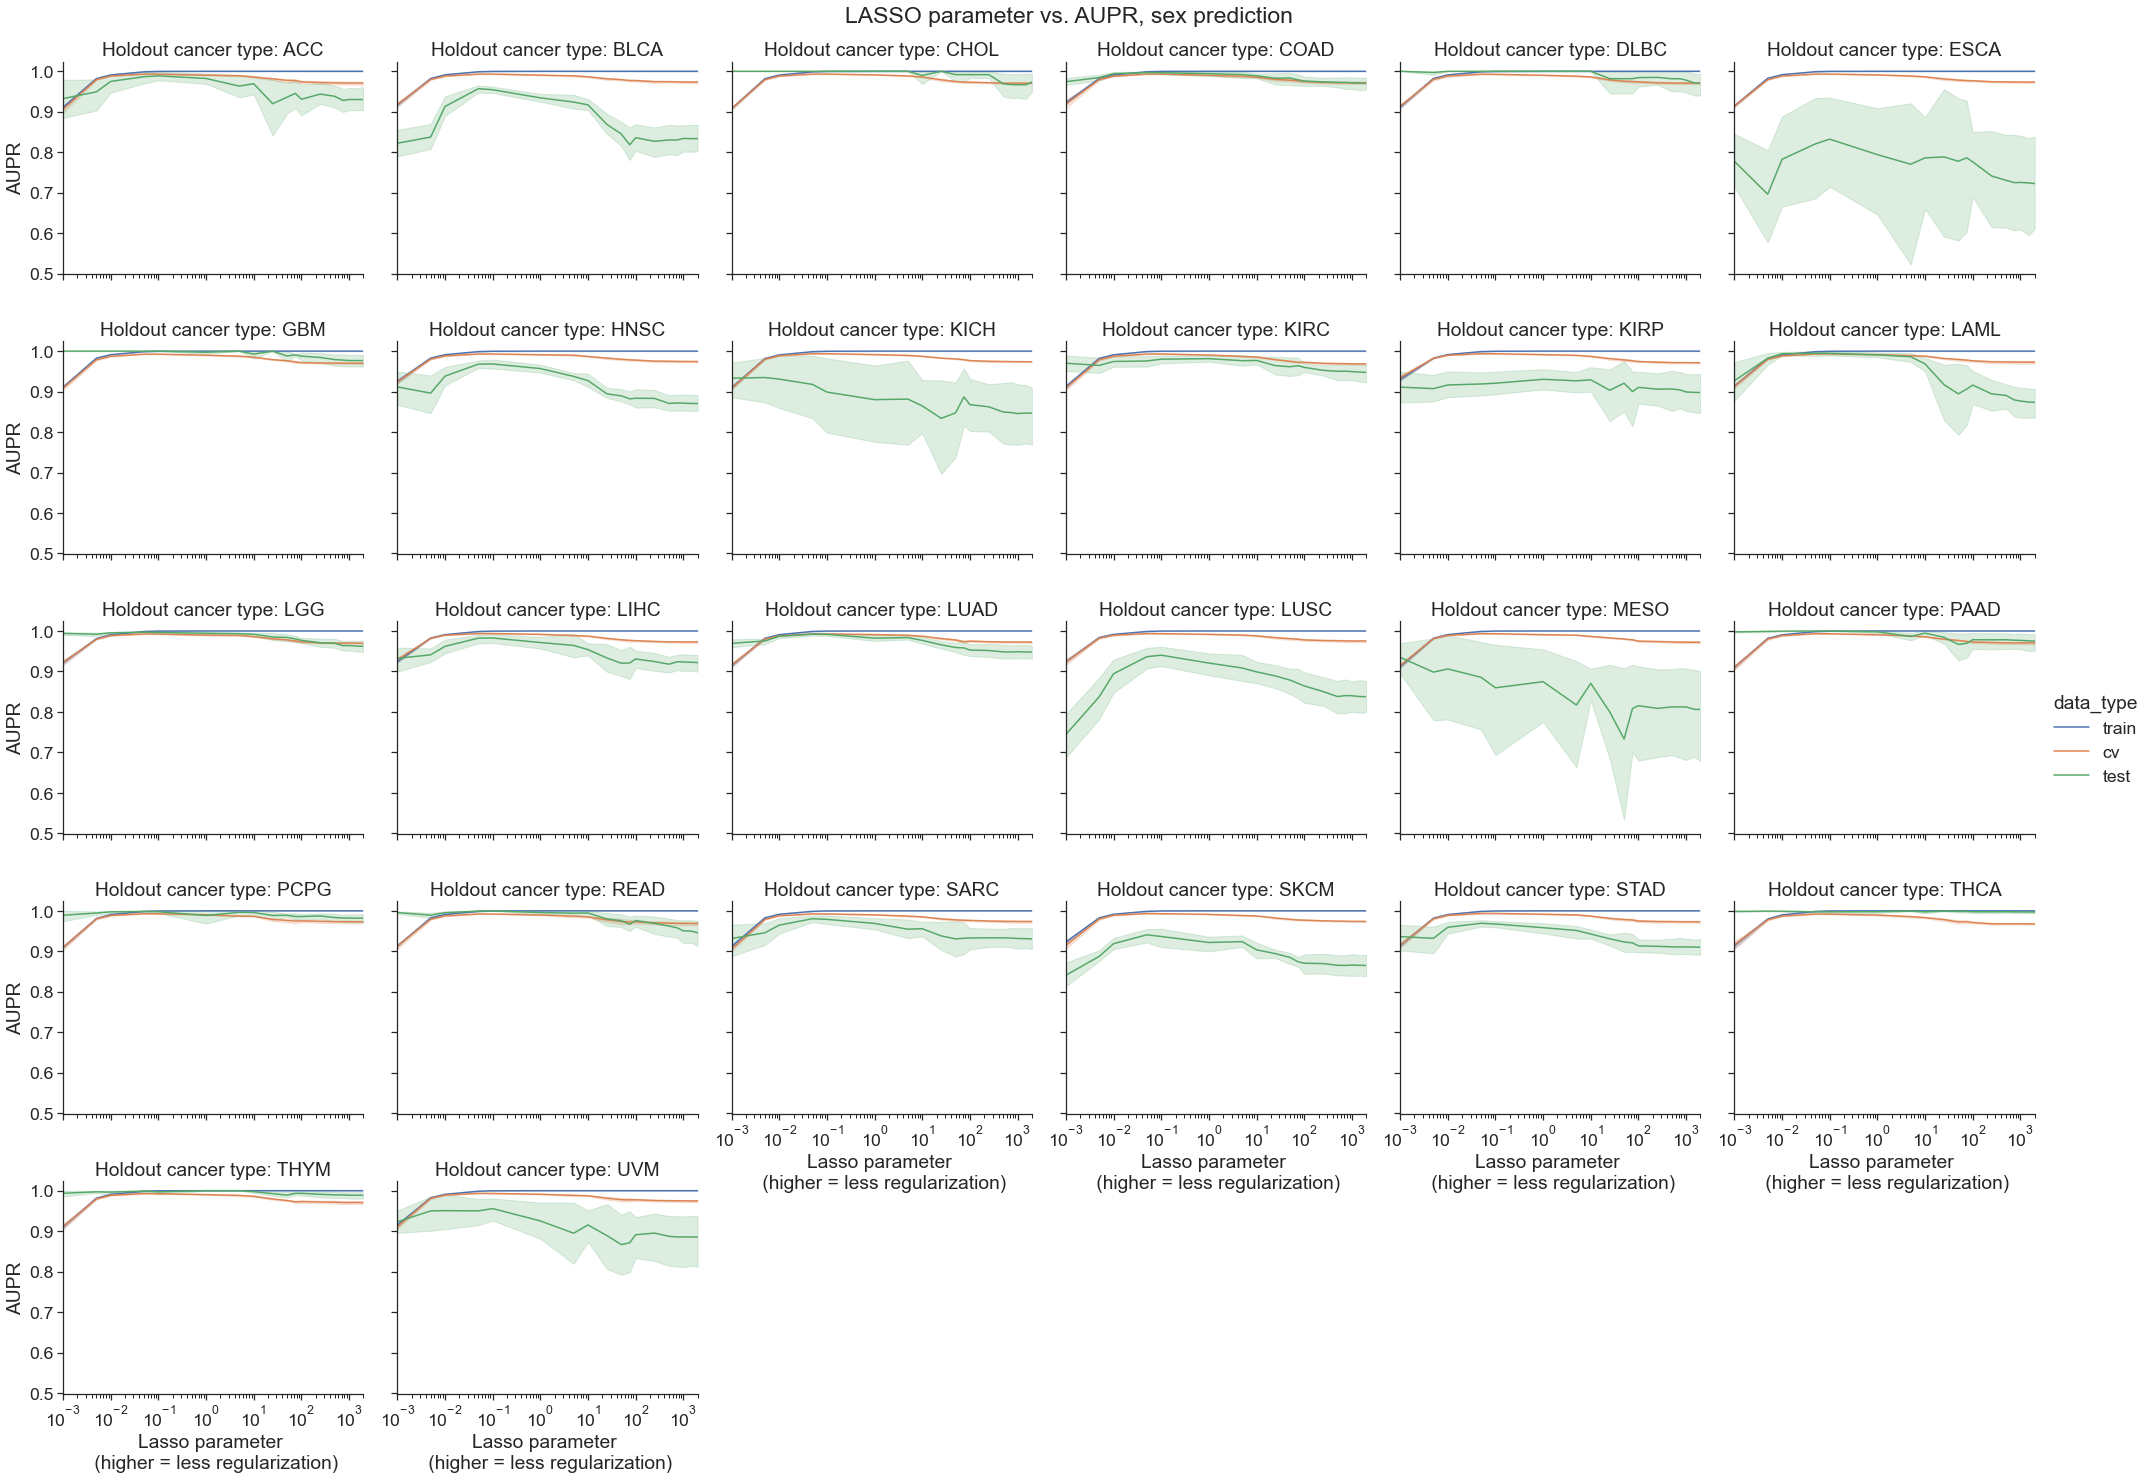

In [7]:
# try with a float-valued x-axis
# this is probably more "correct" than treating each lasso parameter as a
# category (above plot); here the spaces between parameters reflect their
# actual real-valued distance in log-space
# sns.set({'figure.figsize': (12, 5)})
sns.set_style('ticks')

plot_df = (
    perf_df[(perf_df.signal == 'signal')]
      .sort_values(by=['holdout_cancer_type', 'lasso_param'])
      .reset_index(drop=True)
)
plot_df.lasso_param = plot_df.lasso_param.astype(float)

with sns.plotting_context('notebook', font_scale=1.6):
    g = sns.relplot(
        data=plot_df,
        x='lasso_param', y=metric, hue='data_type',
        hue_order=['train', 'cv', 'test'],
        kind='line', col='holdout_cancer_type',
        col_wrap=6, height=4, aspect=1.2
    )
    g.set(xscale='log', xlim=(min(plot_df.lasso_param), max(plot_df.lasso_param)))
    g.set_titles('Holdout cancer type: {col_name}')
    g.set_xlabels('Lasso parameter \n (higher = less regularization)')
    g.set_ylabels(f'{metric.upper()}')
    plt.suptitle(f'LASSO parameter vs. {metric.upper()}, sex prediction', y=1.01)

if output_plots:
    plt.savefig(output_plots_dir / f'sex_lasso_facets.png',
                dpi=200, bbox_inches='tight')

### Plot performance vs. nonzero coefficient count

Since different models (across seeds/folds) have slightly different numbers of nonzero coefficients, the easiest way to do this is to "bin" the models by coefficient count. Here we'll just divide the space of possible feature counts into 10 quantiles, then bin models into those.

In [8]:
plot_df = (
    perf_df[(perf_df.signal == 'signal')]
      .merge(nz_coefs_df, left_on=['holdout_cancer_type', 'lasso_param', 'seed', 'fold'],
             right_on=['cancer_type', 'lasso_param', 'seed', 'fold'])
      .drop(columns=['cancer_type'])
      .sort_values(by=['holdout_cancer_type', 'lasso_param'])
      .reset_index(drop=True)
)
plot_df.lasso_param = plot_df.lasso_param.astype(float)
plot_df.head()

,auroc,aupr,holdout_cancer_type,signal,seed,data_type,fold,experiment,lasso_param,nz_coefs
0,0.93379,0.91395,ACC,signal,42,train,0,all_other_cancers,0.001,2
1,0.90909,0.93615,ACC,signal,42,test,0,all_other_cancers,0.001,2
2,0.93562,0.92383,ACC,signal,42,cv,0,all_other_cancers,0.001,2
3,0.93235,0.91517,ACC,signal,42,train,1,all_other_cancers,0.001,2
4,0.92308,0.96273,ACC,signal,42,test,1,all_other_cancers,0.001,2


,quantile,value
0,0.1,53.0
1,0.2,476.0
2,0.3,842.0
3,0.4,4358.0
4,0.5,12554.0
5,0.6,14522.0
6,0.7,15208.0
7,0.8,15281.0
8,0.9,15320.0


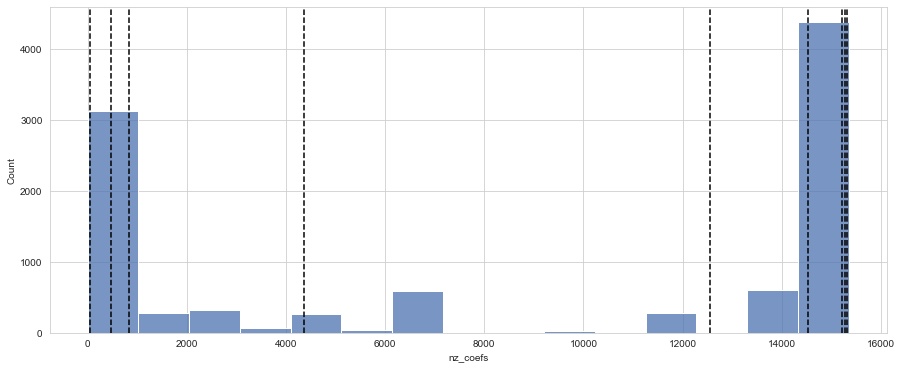

In [9]:
sns.set({'figure.figsize': (15, 6)})
sns.set_style('whitegrid')
sns.histplot(plot_df.nz_coefs)

quantiles_df = []

for q in np.linspace(0.1, 0.9, 9):
    quantiles_df.append([q, plot_df.nz_coefs.quantile(q)])
    plt.gca().axvline(x=plot_df.nz_coefs.quantile(q), color='black', linestyle='--')
    
quantiles_df = pd.DataFrame(quantiles_df, columns=['quantile', 'value'])
quantiles_df

In [10]:
plot_df['nz_quantile'] = pd.qcut(
    plot_df.nz_coefs,
    q=np.linspace(0, 1, 11),
    labels=[f'{q}' for q in range(1, 11)]
)

print(plot_df.nz_quantile.unique())
plot_df.head()

['1', '2', '3', '4', '5', '6', '7', '8', '9', '10']
Categories (10, object): ['1' < '2' < '3' < '4' ... '7' < '8' < '9' < '10']


,auroc,aupr,holdout_cancer_type,signal,seed,data_type,fold,experiment,lasso_param,nz_coefs,nz_quantile
0,0.93379,0.91395,ACC,signal,42,train,0,all_other_cancers,0.001,2,1
1,0.90909,0.93615,ACC,signal,42,test,0,all_other_cancers,0.001,2,1
2,0.93562,0.92383,ACC,signal,42,cv,0,all_other_cancers,0.001,2,1
3,0.93235,0.91517,ACC,signal,42,train,1,all_other_cancers,0.001,2,1
4,0.92308,0.96273,ACC,signal,42,test,1,all_other_cancers,0.001,2,1


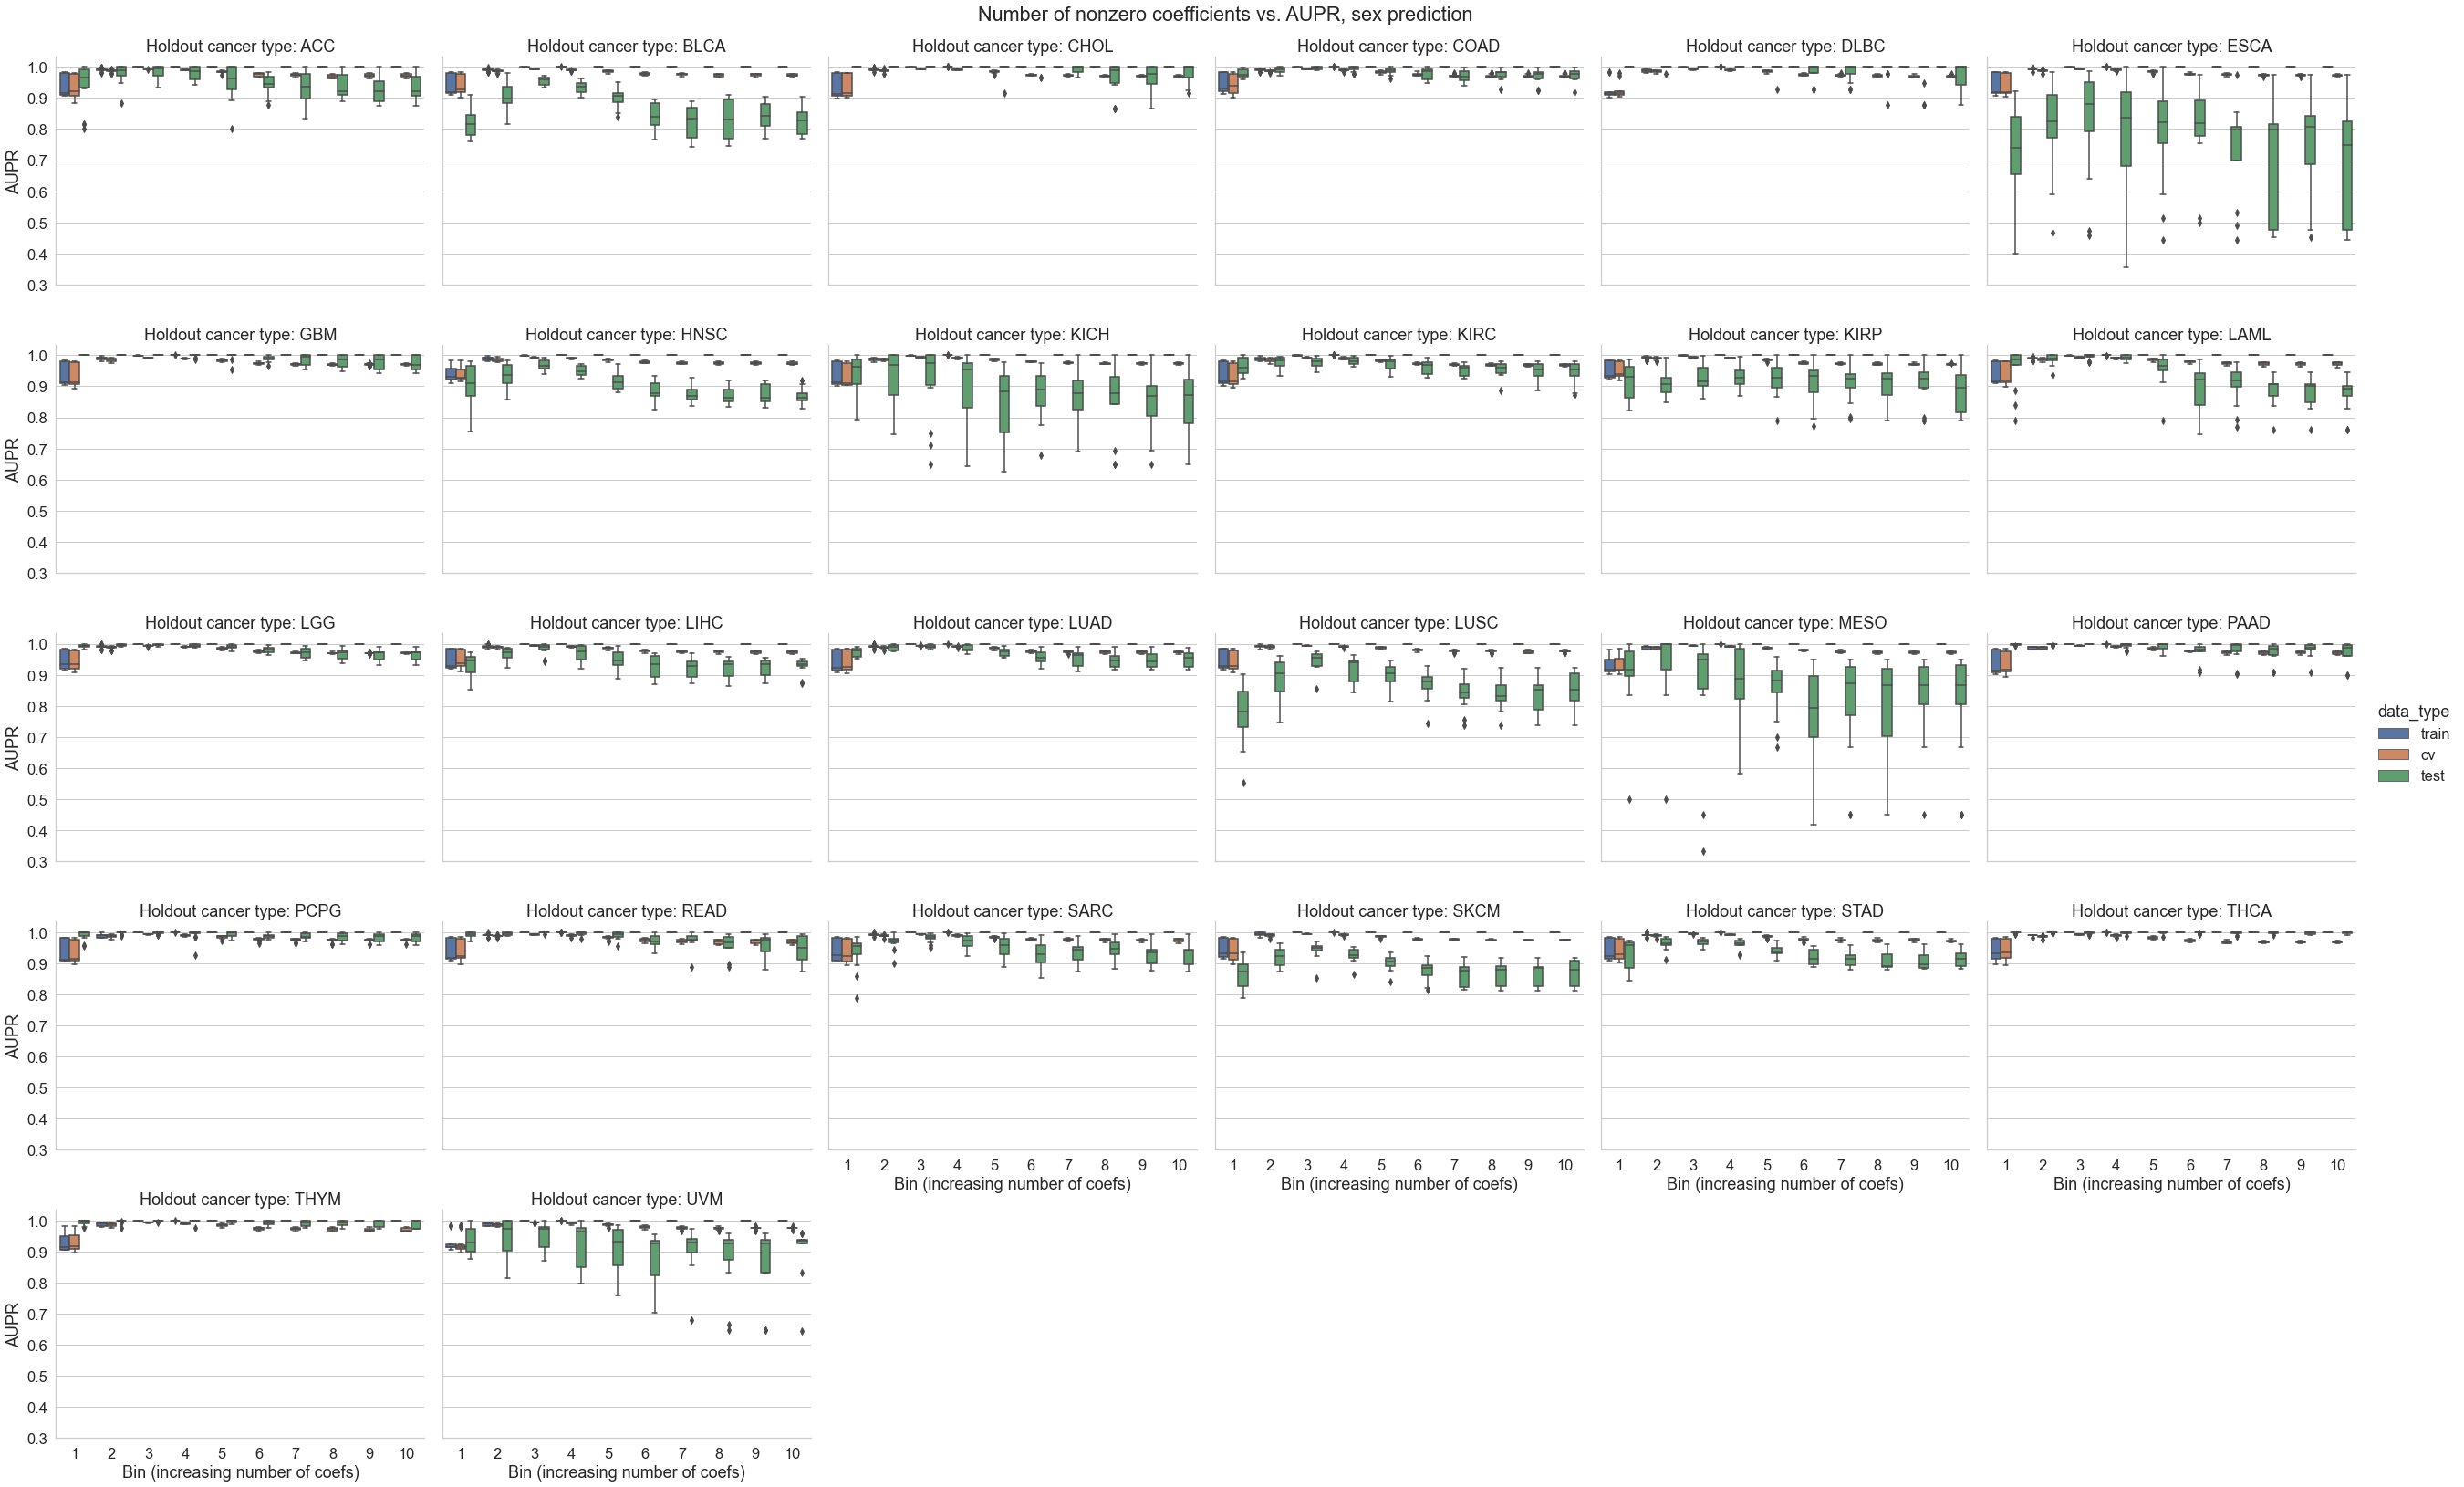

In [11]:
sns.set_style('whitegrid')

with sns.plotting_context('notebook', font_scale=1.5):
    g = sns.catplot(
        data=plot_df,
        x='nz_quantile', y=metric, hue='data_type',
        hue_order=['train', 'cv', 'test'],
        kind='box', col='holdout_cancer_type',
        col_wrap=6, height=4.5, aspect=1.35
    )
    g.set_titles('Holdout cancer type: {col_name}')
    g.set_xlabels('Bin (increasing number of coefs)')
    g.set_ylabels(f'{metric.upper()}')
    plt.suptitle(f'Number of nonzero coefficients vs. {metric.upper()}, sex prediction', y=1.01)

if output_plots:
    plt.savefig(output_plots_dir / f'sex_lasso_bins_boxes.png',
                dpi=200, bbox_inches='tight')

Observations:

* Although it varies by cancer type, performance is generally best for models having hundreds to thousands of features. This is a bit surprising since we expected the number of genes that are most predictive of sex prediction to be considerably smaller (i.e. just pick genes on the X/Y chromosomes). We could try only including those genes in the model to see how performance compares.
* Performance on the held-out cancer type (green lines above) generally more or less tracks with performance on the validation data (orange lines above), but there are a few examples where for small models validation performance is good but holdout performance is not so good (e.g. BLCA, HNSC, LUSC). This is more or less the opposite of what we would expect if small models tended to generalize better.